### Imports

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
import os
sys.path.append('../')
import copy, pdb, json, pprint, glob, cv2, logging, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from yaml import safe_load
from utils import load_domain
from detectors import Dataset, MVTechDataset
from hypersearch import OptunaOptimization
from criteria import Label, accuracy, iou, auc_odr
from ext import SddCxxParameter, SddCxx
from timeit import default_timer as timer
from detectors import SddCxxPSD, PSDParameter

logger = logging.getLogger()
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [8]:
with open('../settings.yml', 'r') as fp:
    settings = safe_load(fp)

dic = load_domain('../domain.json')

### Dataset

Set dataset name

In [9]:
target = 'pill'

In [10]:
dataset_root = f'../data/{target}/'

train_imgs_path = glob.glob(f'{dataset_root}/train/good/*.png')
train_imgs = [cv2.imread(i) for i in train_imgs_path]

test_imgs_path = glob.glob(f'{dataset_root}/test/ALL/*.png')
test_imgs = [cv2.imread(i) for i in test_imgs_path]
test_labels = []
for path in test_imgs_path:
    if 'OK' in path:
        test_labels.append(0)
    else:
        test_labels.append(1)
pd.Series(test_labels).value_counts()

1    141
0     26
Name: count, dtype: int64

In [11]:
dataset = MVTechDataset(train_imgs_path, train_imgs, test_imgs_path, test_imgs, test_labels)

### Domain & Settings

Comment out/in the intended resnet

In [12]:
# onnx_path = os.path.abspath("../distfiles/wide_resnet50_2-95faca4d.onnx")
onnx_path = os.path.abspath("../distfiles/resnet18-5c106cde.onnx")

dic['PSD'][2]['domain'] = onnx_path
dic['PSD'][1]['domain']="../license/node-locked.lic"

Set parameter ranges

In [13]:
#n_features
dic['PSD'][3]['type'] = 'discrete'
dic['PSD'][3]['domain'] = [50, 256] # 50, 256

#b_soe
dic['PSD'][6]['type'] = 'categorical'
dic['PSD'][6]['domain'] = [False, True]
#b_aer
dic['PSD'][7]['type'] = 'categorical'
dic['PSD'][7]['domain'] = [False, True]

#ridge
dic['PSD'][4]['type'] = 'continuous'
dic['PSD'][4]['domain'] = [0.0005, 0.15]
#r_growth
dic['PSD'][5]['type'] = 'continuous'
dic['PSD'][5]['domain'] = [0.0075, 0.15]


In [14]:
for pn in dic['PSD']:
    print(pn)

{'name': 'alg', 'type': 'fixed', 'domain': 'PatchSampleDetector'}
{'name': 'license_path', 'type': 'fixed', 'domain': '../license/node-locked.lic'}
{'name': 'onnx', 'type': 'fixed', 'domain': 'c:\\Users\\12192\\Desktop\\Hacarus\\hyper\\hacarus-check-hyper-search\\src\\backend\\distfiles\\resnet18-5c106cde.onnx'}
{'name': 'n_features', 'type': 'discrete', 'domain': [50, 256]}
{'name': 'ridge', 'type': 'continuous', 'domain': [0.0005, 0.15]}
{'name': 'r_growth', 'type': 'continuous', 'domain': [0.0075, 0.15]}
{'name': 'b_soe', 'type': 'categorical', 'domain': [False, True]}
{'name': 'b_aer', 'type': 'categorical', 'domain': [False, True]}
{'name': 'threshold', 'type': 'continuous', 'domain': [0.1, 0.6]}
{'name': 'area', 'type': 'continuous', 'domain': [1.0, 200.0]}


Check Dictionary

In [15]:
# check dict
dic['PSD']

[{'name': 'alg', 'type': 'fixed', 'domain': 'PatchSampleDetector'},
 {'name': 'license_path',
  'type': 'fixed',
  'domain': '../license/node-locked.lic'},
 {'name': 'onnx',
  'type': 'fixed',
  'domain': 'c:\\Users\\12192\\Desktop\\Hacarus\\hyper\\hacarus-check-hyper-search\\src\\backend\\distfiles\\resnet18-5c106cde.onnx'},
 {'name': 'n_features', 'type': 'discrete', 'domain': [50, 256]},
 {'name': 'ridge', 'type': 'continuous', 'domain': [0.0005, 0.15]},
 {'name': 'r_growth', 'type': 'continuous', 'domain': [0.0075, 0.15]},
 {'name': 'b_soe', 'type': 'categorical', 'domain': [False, True]},
 {'name': 'b_aer', 'type': 'categorical', 'domain': [False, True]},
 {'name': 'threshold', 'type': 'continuous', 'domain': [0.1, 0.6]},
 {'name': 'area', 'type': 'continuous', 'domain': [1.0, 200.0]}]

#### Set n_trials / timeout

In [16]:
minutes = 60*3
timeout_seconds = 60 * minutes 

In [17]:
n_trials = 300

settings['n_trials'] = n_trials
settings

{'dataset_dir': 'dataset',
 'imgs_dir': 'imgs',
 'mask_dir': 'mask',
 'ground_truth_dir': 'ground_truth',
 'algorithm': 'PSD',
 'save_dir': 'Model',
 'n_trials': 300}

### Optuna

In [18]:
pt = OptunaOptimization(dataset=dataset, 
                        criteria=auc_odr,
                        param_space=dic['PSD'], 
                        settings=settings,
                        show_progress_bar=True, 
                        timeout=timeout_seconds,
                        threshold=None, 
                        area=None,
                        seed=1)

res=pt.optimize()
print("Optuna finished.")
best_trial = res[2]
best_score = res[1]
best_param = res[0]

print(best_score)

# puts the results in a df
results_df = pd.DataFrame(pt.params_dict).T
auc_odr_df = pd.DataFrame({'odr': pt.odr_dict, 'auc': pt.auc_dict})
balanced_metrics_df = pd.DataFrame(pt.balanced_metrics_dict).T

# combines the two dfs
results_df = pd.concat([results_df, auc_odr_df, balanced_metrics_df], axis=1)
results_df = results_df[['odr', 'auc', 'n_features', 
                         'ridge', 'r_growth', 
                         'balanced_odr', 'ok_acc', 'ng_acc', 'balanced_threshold',
                         'b_soe', 'b_aer', 
                         'alg', 'license_path', 'onnx', ]]
results_df['license_path']= results_df.license_path.apply(lambda x: x.split('/')[-1])
results_df['onnx']= results_df.onnx.apply(lambda x: x.split('\\')[-1])
value_col = results_df['auc'] - results_df['odr']
results_df.insert(0, 'value', value_col)

# saves the results in the datasets folder
results_path = dataset_root + '/results/'
# make results folder if it doesn't exist
if not os.path.exists(results_path): os.makedirs(results_path)
csvs_count = len(glob.glob(os.path.join(results_path, '*.csv')))
results_csv_path = results_path + f'/optuna_results{csvs_count}.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"\nResults csv saved to {results_csv_path}")

start Optuna optimization
start Optuna optimization


[I 2023-06-12 14:11:24,774] A new study created in memory with name: hyper tune
c:\Users\12192\AppData\Local\pypoetry\Cache\virtualenvs\backend-bJJBwELJ-py3.10\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/300 [00:00<?, ?it/s]

model_params: {'alg': 'PatchSampleDetector', 'license_path': '../license/node-locked.lic', 'onnx': 'c:\\Users\\12192\\Desktop\\Hacarus\\hyper\\hacarus-check-hyper-search\\src\\backend\\distfiles\\resnet18-5c106cde.onnx', 'n_features': 136, 'ridge': 0.10818851176960263, 'r_growth': 0.007516298411471646, 'b_soe': False, 'b_aer': True}
model_params: {'alg': 'PatchSampleDetector', 'license_path': '../license/node-locked.lic', 'onnx': 'c:\\Users\\12192\\Desktop\\Hacarus\\hyper\\hacarus-check-hyper-search\\src\\backend\\distfiles\\resnet18-5c106cde.onnx', 'n_features': 136, 'ridge': 0.10818851176960263, 'r_growth': 0.007516298411471646, 'b_soe': False, 'b_aer': True}
[I 2023-06-12 14:11:47,219] Trial 0 finished with value: -0.5201854882705945 and parameters: {'n_features': 136, 'ridge': 0.10818851176960263, 'r_growth': 0.007516298411471646, 'b_soe': False, 'b_aer': True, 'threshold': 0.2727803635215239, 'area': 79.95672737190331}. Best is trial 0 with value: -0.5201854882705945.
model_params

### Look at results

In [30]:
results_df.sort_values(by='value', ascending=False).head(5)#.sort_values(by='n_features')

,value,odr,auc,n_features,ridge,r_growth,balanced_odr,ok_acc,ng_acc,balanced_threshold,b_soe,b_aer,alg,license_path,onnx
134,-0.010638,0.884615,0.873977,222,0.000721,0.099135,0.1923,0.8077,0.9078,0.9677,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
126,-0.013366,0.884615,0.871249,212,0.001561,0.093913,0.1923,0.8077,0.8723,0.9177,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
129,-0.014730,0.884615,0.869885,218,0.00055,0.100471,0.1923,0.8077,0.8723,0.9775,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
151,-0.015276,0.884615,0.869340,206,0.002806,0.100724,0.1538,0.8462,0.8652,0.8889,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
125,-0.021277,0.884615,0.863339,233,0.000574,0.09406,0.2308,0.7692,0.8936,0.9732,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx


In [20]:
results_df

,value,odr,auc,n_features,ridge,r_growth,balanced_odr,ok_acc,ng_acc,balanced_threshold,b_soe,b_aer,alg,license_path,onnx
0,-0.520185,1.000000,0.479815,136,0.108189,0.007516,0.2692,0.7308,0.3262,0.0110,False,True,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
1,-0.381342,1.000000,0.618658,161,0.06317,0.105144,0.1154,0.8846,0.4610,0.1894,True,True,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
2,-0.479269,1.000000,0.520731,79,0.030116,0.121606,0.0385,0.9615,0.1560,0.1138,False,True,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
3,-0.196399,0.923077,0.726678,58,0.02589,0.132635,0.1923,0.8077,0.6667,0.5248,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
4,-0.272231,1.000000,0.727769,192,0.125277,0.010106,0.1154,0.8846,0.5745,0.0432,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,-0.054828,0.923077,0.868249,207,0.003269,0.101366,0.2308,0.7692,0.8865,0.8788,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
153,-0.023732,0.884615,0.860884,214,0.000629,0.09128,0.2308,0.7692,0.8865,0.9569,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
154,-0.119749,0.923077,0.803328,179,0.045011,0.09926,0.1154,0.8846,0.6454,0.5234,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
155,-0.051555,0.923077,0.871522,204,0.003991,0.090515,0.2308,0.8077,0.8582,0.8137,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx


In [21]:
results_path = dataset_root + '/results/'
print(f"Results csvs for this dataset: {glob.glob(f'{results_path}/optuna*.csv')}")

Results csvs for this dataset: ['../data/pill//results\\optuna_results0.csv', '../data/pill//results\\optuna_results2.csv']


In [22]:
print(results_csv_path)
results = pd.read_csv(results_csv_path)

../data/pill//results//optuna_results2.csv


In [23]:
results.head()

,value,odr,auc,n_features,ridge,r_growth,balanced_odr,ok_acc,ng_acc,balanced_threshold,b_soe,b_aer,alg,license_path,onnx
0,-0.520185,1.000000,0.479815,136,0.108189,0.007516,0.2692,0.7308,0.3262,0.0110,False,True,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
1,-0.381342,1.000000,0.618658,161,0.063170,0.105144,0.1154,0.8846,0.4610,0.1894,True,True,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
2,-0.479269,1.000000,0.520731,79,0.030116,0.121606,0.0385,0.9615,0.1560,0.1138,False,True,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
3,-0.196399,0.923077,0.726678,58,0.025890,0.132635,0.1923,0.8077,0.6667,0.5248,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
4,-0.272231,1.000000,0.727769,192,0.125277,0.010106,0.1154,0.8846,0.5745,0.0432,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx


In [24]:
results[['value',	'odr',	'auc',	'n_features',	'ridge',	'r_growth',]].corr()

,value,odr,auc,n_features,ridge,r_growth
value,1.000000,-0.732446,0.960826,0.345274,-0.630412,0.172069
odr,-0.732446,1.000000,-0.515061,-0.251879,0.343312,-0.076722
auc,0.960826,-0.515061,1.000000,0.332162,-0.653927,0.185401
n_features,0.345274,-0.251879,0.332162,1.000000,-0.140153,-0.110488
ridge,-0.630412,0.343312,-0.653927,-0.140153,1.000000,-0.284250
r_growth,0.172069,-0.076722,0.185401,-0.110488,-0.284250,1.000000


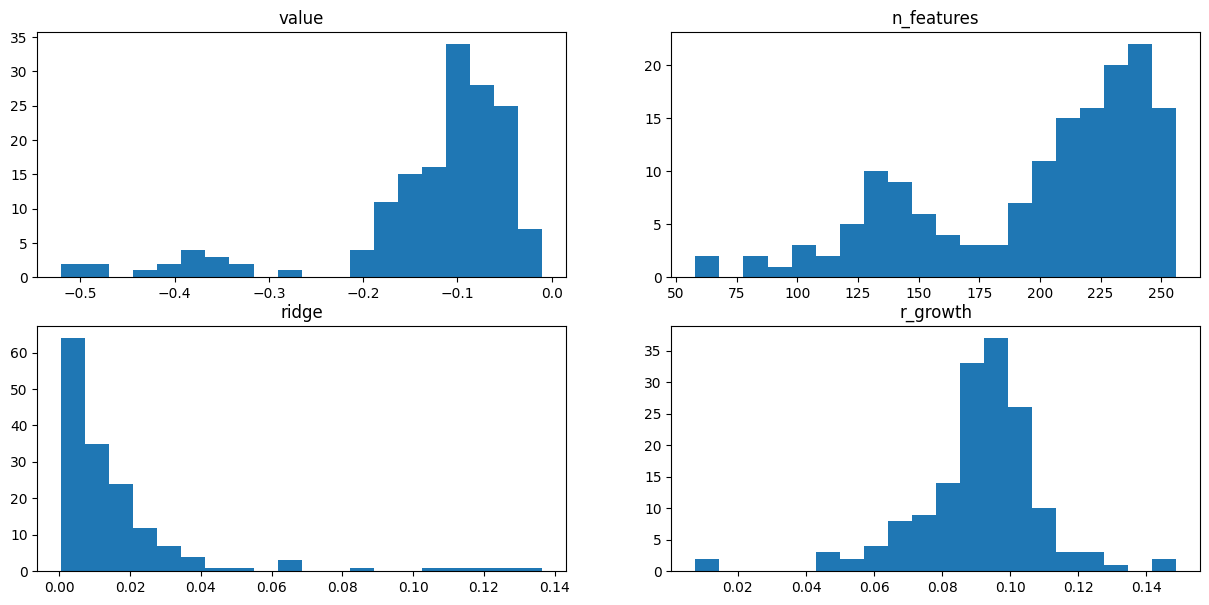

In [25]:
# plot 4 histograms showing value, n_features, ridge, r_growth
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs[0, 0].hist(results['value'], bins=20)
axs[0, 0].set_title('value')
axs[0, 1].hist(results['n_features'], bins=20)
axs[0, 1].set_title('n_features')
axs[1, 0].hist(results['ridge'], bins=20)
axs[1, 0].set_title('ridge')
axs[1, 1].hist(results['r_growth'], bins=20)
axs[1, 1].set_title('r_growth')
plt.show()

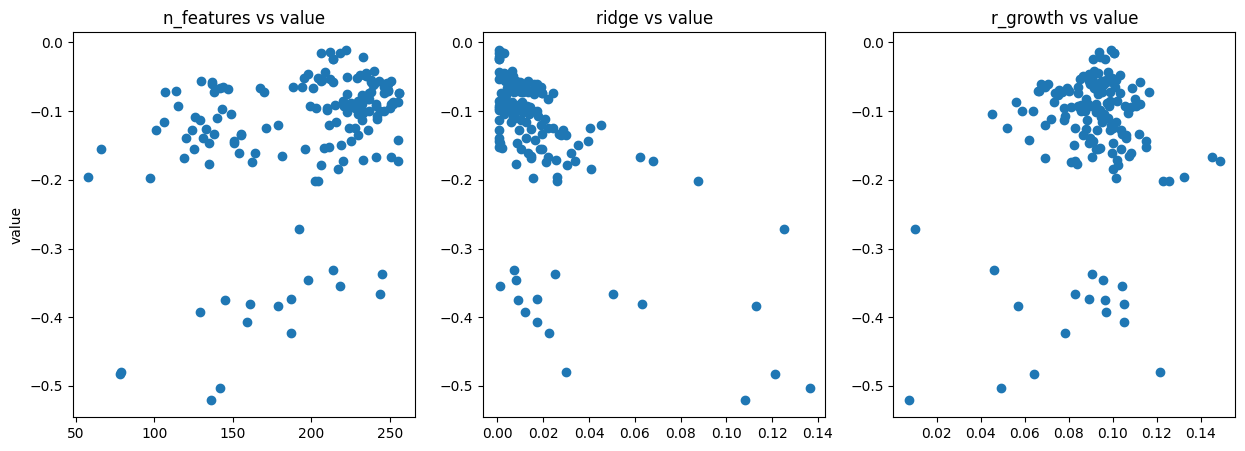

In [26]:
# plot n_features vs value, ridge vs value, r_growth vs value
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_ylabel('value')
axs[0].scatter(results['n_features'], results['value'])
axs[0].set_title('n_features vs value')
axs[1].scatter(results['ridge'], results['value'])
axs[1].set_title('ridge vs value')
axs[2].scatter(results['r_growth'], results['value'])
axs[2].set_title('r_growth vs value')
plt.show()

look at the 20 rows with highest value


In [27]:
results.odr.value_counts()

odr
0.923077    60
0.961538    52
1.000000    37
0.884615     8
Name: count, dtype: int64

In [28]:
results.sort_values(by='value', ascending=False).head(25)#.sort_values(by='n_features')

,value,odr,auc,n_features,ridge,r_growth,balanced_odr,ok_acc,ng_acc,balanced_threshold,b_soe,b_aer,alg,license_path,onnx
134,-0.010638,0.884615,0.873977,222,0.000721,0.099135,0.1923,0.8077,0.9078,0.9677,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
126,-0.013366,0.884615,0.871249,212,0.001561,0.093913,0.1923,0.8077,0.8723,0.9177,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
129,-0.014730,0.884615,0.869885,218,0.000550,0.100471,0.1923,0.8077,0.8723,0.9775,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
151,-0.015276,0.884615,0.869340,206,0.002806,0.100724,0.1538,0.8462,0.8652,0.8889,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
125,-0.021277,0.884615,0.863339,233,0.000574,0.094060,0.2308,0.7692,0.8936,0.9732,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
147,-0.023459,0.884615,0.861157,214,0.000655,0.096622,0.1923,0.8077,0.8440,0.9659,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
153,-0.023732,0.884615,0.860884,214,0.000629,0.091280,0.2308,0.7692,0.8865,0.9569,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
120,-0.041189,0.923077,0.881888,240,0.006483,0.091753,0.1538,0.8462,0.8723,0.7954,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
13,-0.042826,0.923077,0.880251,209,0.000851,0.097911,0.1923,0.8077,0.8936,0.9545,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx
122,-0.044190,0.923077,0.878887,235,0.002815,0.093165,0.1923,0.8077,0.8794,0.8816,True,False,PatchSampleDetector,node-locked.lic,resnet18-5c106cde.onnx


Best Params

In [29]:
best_params = PSDParameter()

best_params.n_features = 77
best_params.ridge = 0.023078
best_params.r_growth = 0.05
best_params.b_soe = False
best_params.b_aer = False
# best_params.onnx = '../distfiles/wide_resnet50_2.onnx'
# best_params.names = ('356', '398', '460')
best_params.onnx = '../distfiles/resnet18.onnx'
# best_params.names = ('140', '156', '172')

balanced_threshold = 0.2804